In [18]:
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import muon
import scanpy as sc
import scvi
import seaborn as sns
import torch
import pandas as pd
import numpy as np
import json
from matplotlib.colors import to_hex

In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.3


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = './'

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Read adata (containing raw CODEX intensities in .obs and raw Xenium counts in .layers['xenium_counts'])

In [4]:
adata = ad.read_h5ad('/media/Lynn/data/Integrated_data/adata/run2_3_codex_raw_xenium_norm100_log_scale_16_umap_leiden_0_7.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 2205205 × 422
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'core_ID', 'slide_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'n_counts', 'tissue', 'time_point', 'patient_ID', 'year', 'cohort', 'run_ID', 'xenium_leiden_0.7', 'xenium_leiden_log', 'slide_str', 'index', 'DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 'CD11c', 'IFNG', 'Pan-Cytokeratin', 'CD68', 'CD20', 'CD66b', 'TNFa', 'CD45RO', 'CD14', 'CD11b', 'Vimentin', 'CD163', 'PDGFRA', 'CD45', 'CCR7', 'IL10', 'CD38', 'CD69', 'Podoplanin', 'PNAd', 'ECP', 'MPO', 'MIP-3', 'slide', 'cropped_region_for_alignment', 'column', 'CD16', 'CXCL13',

In [8]:
adata.layers['counts']= adata.layers['xenium_counts'].copy() #raw xenium data

In [21]:
codex_channels = ['DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 
                 'CD11c', 'IFNG', 'Pan-Cytokeratin', 'CD68', 'CD20', 
                 'CD66b', 'TNFa', 'CD45RO', 'CD14', 'CD11b', 'Vimentin', 
                 'CD163', 'CD45', 'CCR7', 'IL10', 'CD38', 'CD69', 
                 'Podoplanin', 'PNAd'
]

In [13]:
# Extract protein columns from obs as a DataFrame
protein_df = adata.obs[codex_channels]

# Store in obsm as a numpy array
adata.obsm['protein_expression'] = protein_df

## Get starting mdata

In [20]:
X_codex= adata.obsm["protein_expression"].values
X_codex_rounded = np.round(X_codex).astype(int)

# Create new AnnData with the same obs
protein_adata = ad.AnnData(X=X_codex_rounded, obs=adata.obsm["protein_expression"].copy(), var=pd.DataFrame(index=codex_channels))

protein_adata.obs_names = adata.obs_names

del adata.obsm["protein_expression"]

mdata = md.MuData({"rna": adata, "protein": protein_adata})
mdata

/scratch/lyarab/micromamba/envs/totalVI_env/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/scratch/lyarab/micromamba/envs/totalVI_env/lib/python3.11/site-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/scratch/lyarab/micromamba/envs/totalVI_env/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_

MuData object with n_obs × n_vars = 2164608 × 439
  2 modalities
    rna:	2164608 x 422
      obs:	'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'core_ID', 'slide_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'n_counts', 'tissue', 'time_point', 'patient_ID', 'year', 'cohort', 'run_ID', 'xenium_leiden_0.7', 'xenium_leiden_log', 'slide_str', 'index', 'slide', 'cropped_region_for_alignment', 'column', 'xenium_annotation', 'response_group'
      var:	'xenium_n_cells_by_counts', 'xenium_mean_counts', 'xenium_log1p_mean_counts', 'xenium_pct_dropout_by_counts', 'xenium_total_counts', 'xenium_log1p_total_counts', 'xenium_mean', 'xenium_std'
      uns:	'xenium_leiden_0.7', 'xenium_leiden_log_colors', 'xenium_log1p', 'xenium_neighbors', 'xenium_pca', 'xenium_umap', 'log1p'
      obsm:	'spatial', 'xenium_X_pca', 'xenium_X_umap'
      varm:	'xenium_PCs'
      layers:	'xenium_counts', 'counts'
      obsp:	'xenium_connectivities', 'xenium_distances'
    protein:	2164608 x 17
      obs:	'aSMA', 'CD8', 'CD31', 'CD11c', 'IFNG', 'Pan-Cytokeratin', 'CD68', 'CD20', 'CD66b', 'CD45RO', 'CD11b', 'Vimentin', 'CD4_corrected', 'CD45', 'CCR7', 'CD38', 'Podoplanin'

In [21]:
# Add "_CDX" to all protein var_names
mdata.mod['protein'].var_names = [
    f"{name}_CDX" for name in mdata.mod['protein'].var_names
]

In [22]:
mdata.write('"/media/Lynn/data/totalVI/1st_run/mdata/mdata_new.h5mu"')

/scratch/lyarab/micromamba/envs/totalVI_env/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/scratch/lyarab/micromamba/envs/totalVI_env/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


## EULER (after copying the starting mdata from NAS -> EULER)

### Prepare and run the model

In [ ]:
scvi.model.TOTALVI.setup_mudata(
    mdata,
    rna_layer="counts",
    protein_layer=None,
    batch_key="slide_str",
    modalities={
        "rna_layer": "rna",
        "protein_layer": "protein",
        "batch_key": "rna",
    },
)

In [ ]:
model = scvi.model.TOTALVI(mdata)

In [ ]:
model.train(
    train_size=0.9,               # 10% validation set
    max_epochs=400,               # big number; will stop earlier automatically
    accelerator="gpu",            # use Apple GPU
    devices=1,
    early_stopping=True,          # enable early stopping
    early_stopping_patience=20,   # stop after 20 epochs with no improvement
    early_stopping_monitor="elbo_validation",  # monitor validation ELBO
)
model.save("/cluster/work/moor/lynn/totalvi/model/my_model_400_epochs", overwrite=True)

### Get latent representation

In [ ]:
rna = mdata.mod['rna']
protein = mdata.mod['protein']

# arbitrarily store latent in rna modality
TOTALVI_LATENT_KEY = "X_totalVI"
rna.obsm[TOTALVI_LATENT_KEY] = model.get_latent_representation()

### Get denoised rna and protein, and protein foreground probabilies

In [ ]:
rna_denoised, protein_denoised = model.get_normalized_expression(
    n_samples=25, return_mean=True
)
rna.layers["denoised_rna"] = rna_denoised
protein.layers["denoised_protein"] = protein_denoised

protein.layers["protein_foreground_prob"] = 100 * model.get_protein_foreground_probability(
    n_samples=25, return_mean=True
)
parsed_protein_names = [p.split("_")[0] for p in protein.var_names]
protein.var["clean_names"] = parsed_protein_names

mdata.update()
mdata.write("/cluster/work/moor/lynn/totalvi/data/1st_run/mdata_denoised.h5mu")

### Cluster

In [ ]:
TOTALVI_CLUSTERS_KEY = "leiden_totalVI"

sc.pp.neighbors(rna, use_rep=TOTALVI_LATENT_KEY)
sc.tl.umap(rna)
sc.tl.leiden(rna, key_added=TOTALVI_CLUSTERS_KEY)

mdata.update()
mdata.write("/cluster/work/moor/lynn/totalvi/data/1st_run/mdata_leiden.h5mu")

### Dendogram

In [ ]:
sc.tl.dendrogram(rna, groupby=TOTALVI_CLUSTERS_KEY, use_rep=TOTALVI_LATENT_KEY)
# This is a bit of a hack to be able to use scanpy dendrogram with the protein data
protein.obs[TOTALVI_CLUSTERS_KEY] = rna.obs[TOTALVI_CLUSTERS_KEY]
protein.obsm[TOTALVI_LATENT_KEY] = rna.obsm[TOTALVI_LATENT_KEY]
sc.tl.dendrogram(protein, groupby=TOTALVI_CLUSTERS_KEY, use_rep=TOTALVI_LATENT_KEY)

mdata.update()
mdata.write("/cluster/work/moor/lynn/totalvi/data/1st_run/mdata_leiden_dendogram.h5mu")

## Read updated mdata (after copying all Euler outputs to NAS)

In [19]:
mdata = muon.read('/media/Lynn/data/totalVI/1st_run/mdata/mdata_leiden_dendogram.h5mu')

/scratch/lyarab/micromamba/envs/totalVI_env/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/scratch/lyarab/micromamba/envs/totalVI_env/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [20]:
rna = mdata.mod['rna']
protein = mdata.mod['protein']

TOTALVI_LATENT_KEY = "X_totalVI"
TOTALVI_CLUSTERS_KEY = "leiden_totalVI"

In [29]:
rna.write('/media/Lynn/data/totalVI/1st_run/totalVI_rna_adata.h5ad')
protein.write('/media/Lynn/data/totalVI/1st_run/totalVI_protein_adata.h5ad')

## Read in model

In [6]:
model = scvi.model.TOTALVI.load("/media/Lynn/data/totalVI/1st_run/my_model_400_epochs", mdata)

INFO     File /media/Lynn/data/totalVI/3rd_run/3rd_run_model_400_epochs/model.pt already downloaded                
INFO     Computing empirical prior initialization for protein background.                                          


In [7]:
last_val_valid = np.array(model.history["elbo_validation"])[-1]
last_val_train = np.array(model.history["elbo_train"])[-1]
global_min_loss = min(
    np.min(model.history["elbo_train"]), np.min(model.history["elbo_validation"])
)
last_max_loss = max(last_val_train, last_val_valid)[0]
global_max_loss = max(
    np.max(model.history["elbo_train"]), np.max(model.history["elbo_validation"])
)

In [8]:
# Compute the min and max of both train and validation losses
min_loss = min(min(last_val_train, last_val_valid), global_min_loss)
max_loss = max(max(last_val_train, last_val_valid), global_max_loss)
ylim_min = 0.995 * min_loss  # 0.5% below the minimum
ylim_max = min(
    global_max_loss, ylim_min + (last_max_loss - ylim_min) * 4
)  # keep it under the 25% part of figure

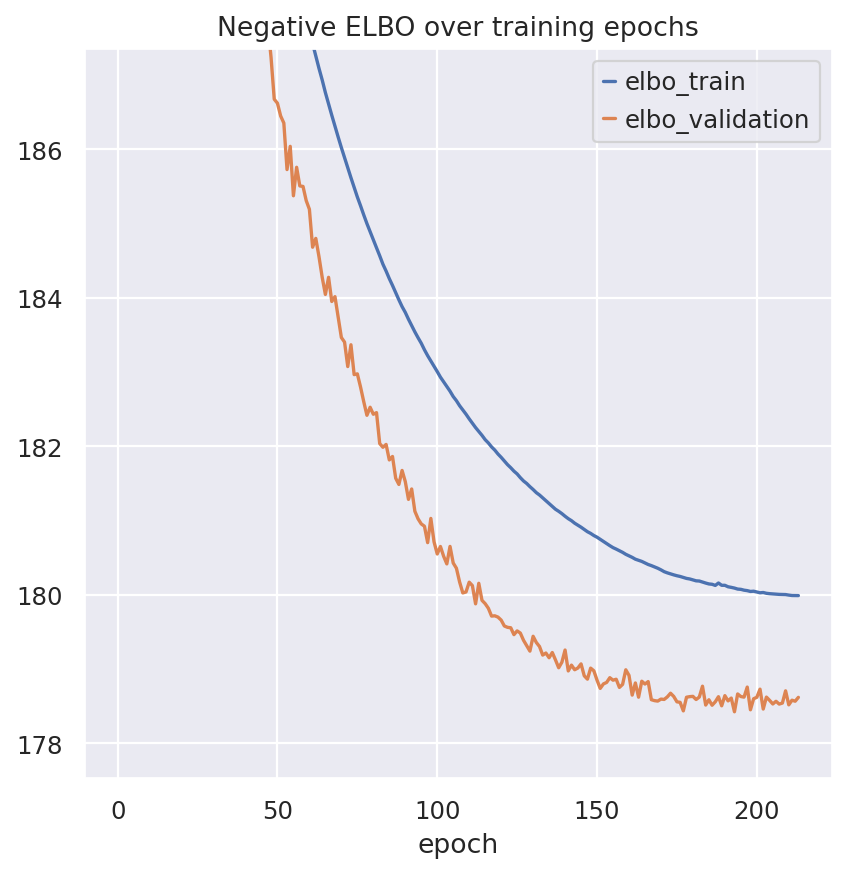

In [9]:
fig, ax = plt.subplots(1, 1)
model.history["elbo_train"].plot(ax=ax, label="train")
model.history["elbo_validation"].plot(ax=ax, label="validation")
if isinstance(ylim_min, (int | float)) and isinstance(ylim_max, (int | float)):
    ax.set(title="Negative ELBO over training epochs", ylim=(ylim_min, ylim_max))
else:
    ax.set(title="Negative ELBO over training epochs")
ax.legend()
fig.savefig("/media/Lynn/notebooks/figures/elbo_training_plot.png", dpi=300, bbox_inches="tight")

## Visualize probability of foreground

In [ ]:
muon.pl.embedding(
    mdata,
    basis="rna:X_umap",
    layer="protein_foreground_prob",
    color=protein.var_names,
    frameon=False,
    ncols=3,
    vmax="p99",
    wspace=0.1,
    color_map="cividis",
    save = '_protein_foreground_prob.png'
)

## Visualize top DE genes by cluster

In [11]:
de_df = model.differential_expression(
    groupby="rna:leiden_totalVI", delta=0.5, batch_correction=True
)
de_df.head(5)

DE...: 100%|██████████| 24/24 [01:47<00:00,  4.48s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
DERL3,0.9220,0.0780,2.469836,0.020601,0.003039,0.00001,0.5,3.821151,3.669134,2.477368,...,0.796408,0.055775,0.386224,0.038313,344.548248,15.113769,False,0 vs Rest,0,Rest
TNFRSF17,0.9160,0.0840,2.389199,0.017522,0.002968,0.00001,0.5,3.585161,3.336652,2.438763,...,0.535865,0.055986,0.327913,0.042624,226.081100,15.318446,False,0 vs Rest,0,Rest
SEC11C,0.8994,0.1006,2.190576,0.045694,0.011331,0.00001,0.5,2.288482,2.279186,1.439332,...,1.585862,0.358667,0.592820,0.210953,615.889343,63.263493,False,0 vs Rest,0,Rest
FKBP11,0.8954,0.1046,2.147127,0.030713,0.008021,0.00001,0.5,2.225107,2.177280,1.398113,...,1.063127,0.238192,0.505819,0.162029,426.982880,47.927589,False,0 vs Rest,0,Rest
SELENOK,0.8842,0.1158,2.032819,0.010544,0.003398,0.00001,0.5,1.767709,1.774491,1.056123,...,0.359773,0.118117,0.262424,0.098838,158.316833,24.152431,False,0 vs Rest,0,Rest


In [12]:
de_df.to_csv("/media/Lynn/data/totalVI/1st_run/DE_results/differential_expression_results.csv")

#### We filter the results such that we retain features above a certain Bayes factor (which here is on the natural log scale) and transcripts with greater than 10% non-zero entries in the cluster of interest.

In [13]:
filtered_pro = {}
filtered_rna = {}
cats = rna.obs[TOTALVI_CLUSTERS_KEY].cat.categories
for c in cats:
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_median", ascending=False)

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 0]

    pro_rows = cell_type_df.index.str.contains("protein")
    data_pro = cell_type_df.iloc[pro_rows]
    data_pro = data_pro[data_pro["bayes_factor"] > 0.7]

    data_rna = cell_type_df.iloc[~pro_rows]
    data_rna = data_rna[data_rna["bayes_factor"] > 3]
    data_rna = data_rna[data_rna["non_zeros_proportion1"] > 0.1]

    filtered_pro[c] = data_pro.index.tolist()[:3]
    filtered_rna[c] = data_rna.index.tolist()[:2]

In [14]:
with open("/media/Lynn/data/totalVI/1st_run/filtered_protein_and_rna/new_filtered_pro.json", "w") as f:
    json.dump(filtered_pro, f)
with open("/media/Lynn/data/totalVI/4th_run_with_cd4/new_filtered_rna.json", "w") as f:
    json.dump(filtered_rna, f)

In [ ]:
sc.pl.dotplot(
    rna,
    filtered_rna,
    groupby=TOTALVI_CLUSTERS_KEY,
    dendrogram=True,
    standard_scale="var",
    swap_axes=True,
    save = '_dendogram_filtered_rna.png'
)

## Visualize mean protein expression by cluster

In [22]:
protein.obs.rename(
    columns={name: f"{name}_CDX_protein" for name in codex_channels if name in protein.obs.columns},
    inplace=True)

In [ ]:
sc.pl.matrixplot(
    protein,
    protein.var["clean_names"],
    groupby=TOTALVI_CLUSTERS_KEY,
    gene_symbols="clean_names",
    dendrogram=True,
    swap_axes=True,
    layer="denoised_protein",
    cmap="Greens",
    standard_scale="var",
    save = '_dendogram_filtered_proteins.png'
)

In [ ]:
muon.pl.embedding(
    mdata,
    basis="rna:X_umap",
    color=protein.var_names,
    frameon=False,
    ncols=3,
    vmax="p99",
    wspace=0.1,
    layer="denoised_protein",
    save = '_codex_markers.png'
)

## Visualize top DE genes and proteins by cluster

In [ ]:
import pandas as pd
from itertools import chain

# Flatten feature dicts
rna_features = list(chain.from_iterable(filtered_rna.values()))
protein_features = list(chain.from_iterable(filtered_pro.values()))

# Remove duplicates while preserving order
rna_features = list(dict.fromkeys(rna_features))
protein_features = list(dict.fromkeys(protein_features))

# Remove "_CDX_protein" suffix
protein_features_clean = [f.replace('_protein', '') for f in protein_features]

# Extract protein values as a DataFrame (cells x features)
protein_df = pd.DataFrame(
    mdata['protein'][:, protein_features_clean].X,
    index=mdata['protein'].obs_names,
    columns=protein_features_clean
)

# Make sure the index matches RNA obs
protein_df = protein_df.loc[mdata['rna'].obs_names]

# Add protein columns to RNA obs
for col in protein_df.columns:
    mdata['rna'].obs[col] = protein_df[col]

# Combine features for dotplot
combined_features = rna_features + protein_features_clean

# Dotplot
import scanpy as sc
sc.pl.dotplot(
    mdata['rna'],
    var_names=combined_features,
    groupby=TOTALVI_CLUSTERS_KEY,
    dendrogram=True,
    standard_scale='var',
    swap_axes=True,
    save='_dendogram_filtered_rna_protein_combined.png'
)


## Add Annotation

In [23]:
annotation_dict = {
    "0": "Plasma Cells",
    "1": "Crypt Epithelial Cells (Colon)",
    "2": "B Cells",
    "3": "Macrophages (tissue resident)",
    "4": "CD8+ T cells",
    "5": "Crypt Cells (Ileum)",
    "6": "Pericryptal Fibroblasts",
    "7": "Neutrophils",
    "8": "Endothelial Cells",
    "9": "Tregs",
    "10": "Smooth Muscle Cells",
    "11": "Enterocytes (Ileum)",
    "12": "Colonocytes (Colon)",
    "13": "Neutrophils CCL4+",
    "14": "Mast Cells",
    "15": "Inflammatory Fibroblasts",
    "16": "Tfh-like CD4⁺ helper Cells",
    "17": "Inflammatory Epithelial Cells (LCN2+ high)",
    "18": "Other",
    "19": "M-Cells (?)",
    "20": "Enteroendocrine Cells (Ileum)",
    "21": "Enteroendocrine Cells (Colon)",
    "22": "Other",
    "23": "Lymphatic Endothelial Cells",
    "24": "Plasmablasts",
    "25": "Tuft Cells",
    "26": "Transit Amplifying Cells (Ileum)",
    "27": "Stem Cells (Colon)"
}

# Map string-based 'leiden' clusters to annotations
rna.obs['annotation'] = rna.obs[TOTALVI_CLUSTERS_KEY].map(annotation_dict)

In [28]:
import pandas as pd
import re

# Extract desired columns
df = rna.obs[['annotation']].copy()

# Add cell_id as a column
df['cell_id'] = rna.obs_names


# Reorder columns
df = df[['cell_id', 'annotation']]

# Save to CSV
output_path = "/media/Lynn/data/run_2_3_final_annotation.csv"
df.to_csv(output_path, index=False)
print(f"Saved cleaned cell metadata to: {output_path}")


Saved cleaned cell metadata to: /media/Lynn/data/run_2_3_final_annotation.csv


In [53]:
df.head()

,cell_id,annotation
cell_id,,
aaaaapoi-1_ID_0056764,aaaaapoi-1_ID_0056764,Crypt Cells (Ileum)
aaaadfjn-1_ID_0056764,aaaadfjn-1_ID_0056764,Crypt Cells (Ileum)
aaaagadk-1_ID_0056764,aaaagadk-1_ID_0056764,Crypt Cells (Ileum)
aaaagmge-1_ID_0056764,aaaagmge-1_ID_0056764,Crypt Cells (Ileum)
aaaahchk-1_ID_0056764,aaaahchk-1_ID_0056764,Crypt Cells (Ileum)
